In [ ]:
import pathlib
import pickle
import random
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from scipy import ndimage

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features']
        # 1D numpy.ndarray type, for train = (34799,)
        target = d['labels']
        # 2D numpy.ndarray type, for train = (34799, 2)
        sizes = d['sizes']
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']

    return input_data, target, sizes, coords

In [ ]:
train_path = "drive/My Drive/Colab Notebooks/lab2_dataset/train.pickle"
test_path = "drive/My Drive/Colab Notebooks/lab2_dataset/test.pickle"
valid_path = "drive/My Drive/Colab Notebooks/lab2_dataset/valid.pickle"
label_names_path = "drive/My Drive/Colab Notebooks/lab2_dataset/label_names.csv"
model_path = lambda name: f"drive/My Drive/Colab Notebooks/lab2_dataset/{name}.model"

In [ ]:
X_train, y_train, *_ = load_data(train_path)
X_test, y_test, *_ = load_data(test_path)
X_valid, y_valid, *_ = load_data(valid_path)

In [ ]:
label_names = pd.read_csv(label_names_path)

In [ ]:
print("Training examples : ", len(X_train))
print("Validation examples : ", len(X_valid))
print("Testing examples : ", len(X_test))
print("Image data shape : ", X_train.shape)
print("Total classes : ", len(set(y_test)))

Training examples :  34799
Validation examples :  4410
Testing examples :  12630
Image data shape :  (34799, 32, 32, 3)
Total classes :  43


In [ ]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()

        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)

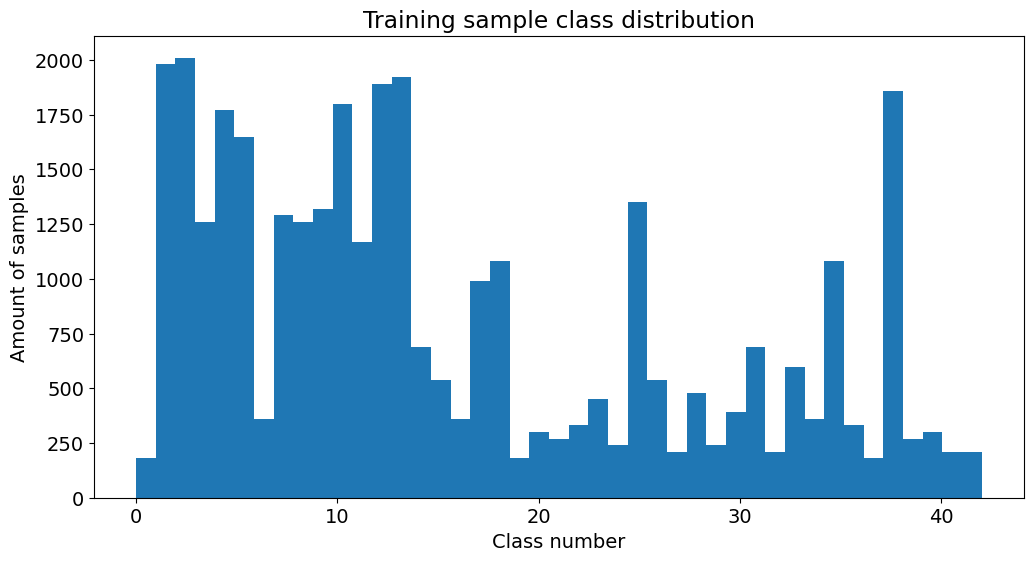

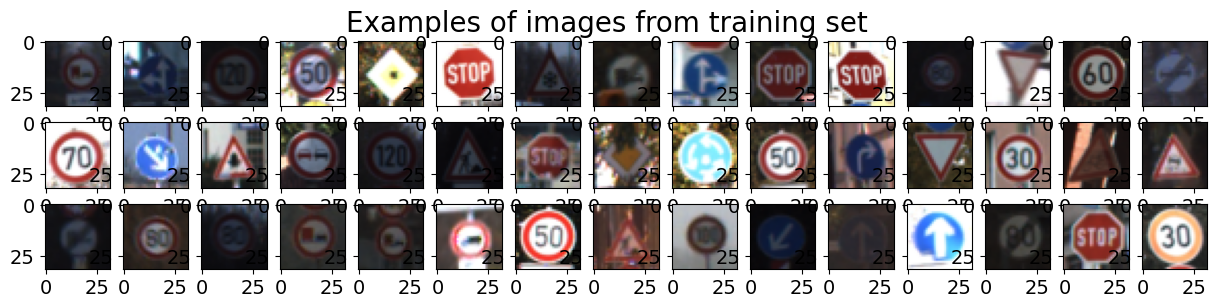

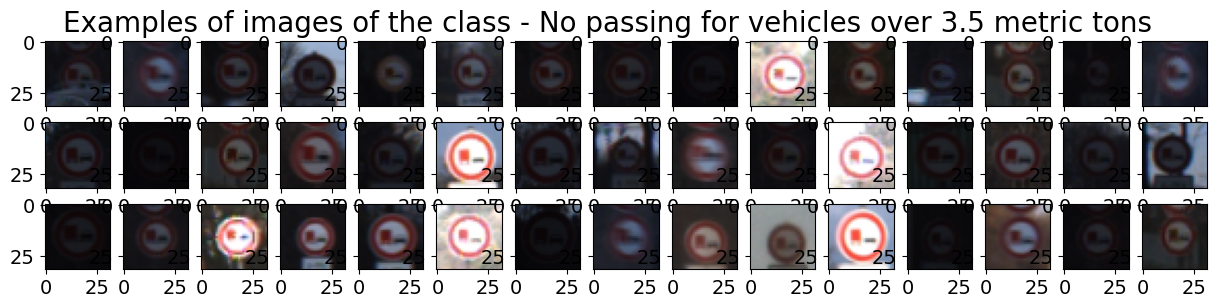

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

draw_images_examples(X_train, 15, 3, 'Examples of images from training set')

example_class = y_train[random.randint(0, len(y_train))]

X_train_one_label = X_train[np.where(y_train==example_class)]
draw_images_examples(X_train_one_label, 15, 3, f'Examples of images of the class - {label_names["SignName"][example_class]}')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [ ]:
class TrafficSignDataset(Dataset):
    def __init__(self, path, transform=None):
        self.X, self.y, *_ = load_data(path)
        self.count = len(self.y)
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform is not None:
            X = self.transform(X)
        return (X, self.y[index])

    def __len__(self):
        return self.count

In [ ]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield (self.func(*batch))

In [ ]:
class LeNet(nn.Module):
    def __init__(self, gray=False):
        super(LeNet, self).__init__()
        input_channels = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def loss(model, loss_func, X, y, optimizer=None):
    loss = loss_func(model(X), y)
    if optimizer is not None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss.item(), len(X)

In [ ]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss.item(), torch.sum(correct).item(), len(X)

In [ ]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [ ]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(n_epochs) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(n_epochs) if x % 2 == 1])
    plt.show()

In [ ]:
def train(model, criterion, optimizer, n_epochs, transforms, saving_model_path=None, custom_train_path=None):
    if custom_train_path is not None:
        train_dataset = TrafficSignDataset(custom_train_path, transform=transforms)
    else:
        train_dataset = TrafficSignDataset(train_path, transform=transforms)
    valid_dataset = TrafficSignDataset(valid_path, transform=transforms)
    test_dataset = TrafficSignDataset(test_path, transform=transforms)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)

In [ ]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20


Fitting nn model


  5%|▌         | 1/20 [00:10<03:23, 10.70s/it]


epoch:   1, loss: 2.34339, valid loss: 1.32356, valid accruacy: 61.633%
Validation loss decreased (inf --> 1.323557). Saving model...


 10%|█         | 2/20 [00:14<01:57,  6.55s/it]


epoch:   2, loss: 0.73506, valid loss: 0.82379, valid accruacy: 77.937%
Validation loss decreased (1.323557 --> 0.823794). Saving model...


 15%|█▌        | 3/20 [00:17<01:21,  4.81s/it]


epoch:   3, loss: 0.38626, valid loss: 0.58202, valid accruacy: 84.580%
Validation loss decreased (0.823794 --> 0.582021). Saving model...


 20%|██        | 4/20 [00:19<01:04,  4.01s/it]


epoch:   4, loss: 0.25315, valid loss: 0.52692, valid accruacy: 86.032%
Validation loss decreased (0.582021 --> 0.526916). Saving model...


 25%|██▌       | 5/20 [00:22<00:53,  3.57s/it]


epoch:   5, loss: 0.17920, valid loss: 0.47631, valid accruacy: 87.982%
Validation loss decreased (0.526916 --> 0.476308). Saving model...


 30%|███       | 6/20 [00:25<00:48,  3.44s/it]


epoch:   6, loss: 0.14116, valid loss: 0.55626, valid accruacy: 87.778%


 35%|███▌      | 7/20 [00:29<00:44,  3.39s/it]


epoch:   7, loss: 0.10843, valid loss: 0.48775, valid accruacy: 89.025%


 40%|████      | 8/20 [00:31<00:38,  3.20s/it]


epoch:   8, loss: 0.09210, valid loss: 0.53575, valid accruacy: 88.073%


 45%|████▌     | 9/20 [00:34<00:33,  3.07s/it]


epoch:   9, loss: 0.07497, valid loss: 0.45630, valid accruacy: 90.068%
Validation loss decreased (0.476308 --> 0.456300). Saving model...


 50%|█████     | 10/20 [00:37<00:29,  2.98s/it]


epoch:  10, loss: 0.06104, valid loss: 0.53163, valid accruacy: 90.726%


 55%|█████▌    | 11/20 [00:41<00:28,  3.16s/it]


epoch:  11, loss: 0.05448, valid loss: 0.40927, valid accruacy: 91.701%
Validation loss decreased (0.456300 --> 0.409273). Saving model...


 60%|██████    | 12/20 [00:43<00:24,  3.08s/it]


epoch:  12, loss: 0.04892, valid loss: 0.54827, valid accruacy: 90.794%


 65%|██████▌   | 13/20 [00:46<00:21,  3.00s/it]


epoch:  13, loss: 0.04363, valid loss: 0.50336, valid accruacy: 91.088%


 70%|███████   | 14/20 [00:49<00:18,  3.07s/it]


epoch:  14, loss: 0.03808, valid loss: 0.43618, valid accruacy: 91.701%


 75%|███████▌  | 15/20 [00:53<00:15,  3.10s/it]


epoch:  15, loss: 0.03019, valid loss: 0.40881, valid accruacy: 92.154%
Validation loss decreased (0.409273 --> 0.408808). Saving model...


 80%|████████  | 16/20 [00:56<00:12,  3.16s/it]


epoch:  16, loss: 0.02880, valid loss: 0.47886, valid accruacy: 91.293%


 85%|████████▌ | 17/20 [01:00<00:09,  3.29s/it]


epoch:  17, loss: 0.02968, valid loss: 0.47068, valid accruacy: 91.429%


 90%|█████████ | 18/20 [01:02<00:06,  3.13s/it]


epoch:  18, loss: 0.02295, valid loss: 0.41307, valid accruacy: 91.179%


 95%|█████████▌| 19/20 [01:05<00:03,  3.04s/it]


epoch:  19, loss: 0.02079, valid loss: 0.50864, valid accruacy: 91.950%


100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


epoch:  20, loss: 0.02261, valid loss: 0.54671, valid accruacy: 91.111%
Fit time: 69.24330949783325 s


Test loss: 0.72415	Test accruacy: 91.061%
Saving model


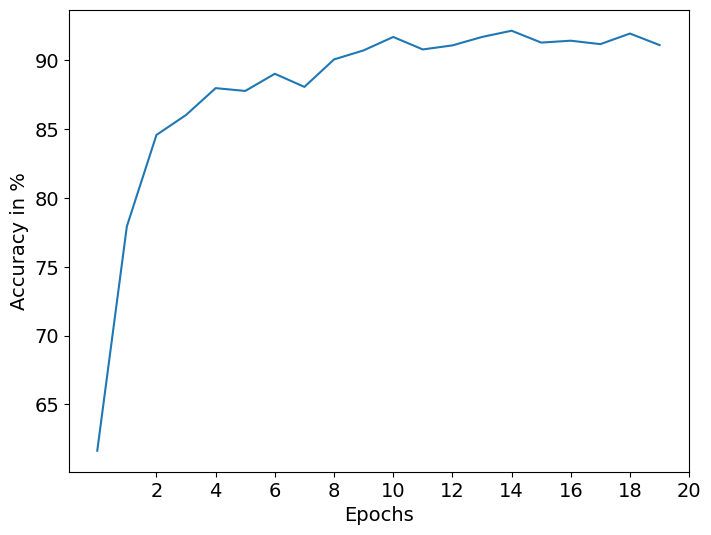

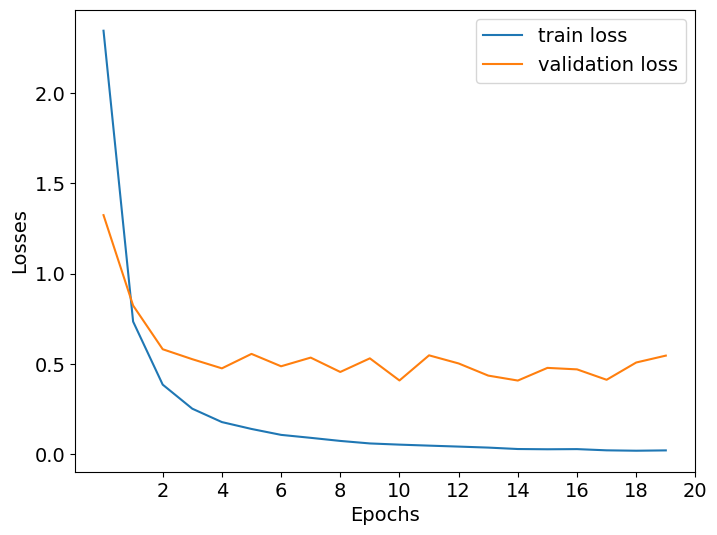

In [ ]:
train(model, criterion, optimizer, n_epochs, transforms.ToTensor(), 'base_model')

In [ ]:
def apply_clahe(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)[:,:,0]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    img = clahe.apply(img)

    img = img.reshape(img.shape + (1,))

    return img

In [ ]:
def normalize(img):
    return cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)

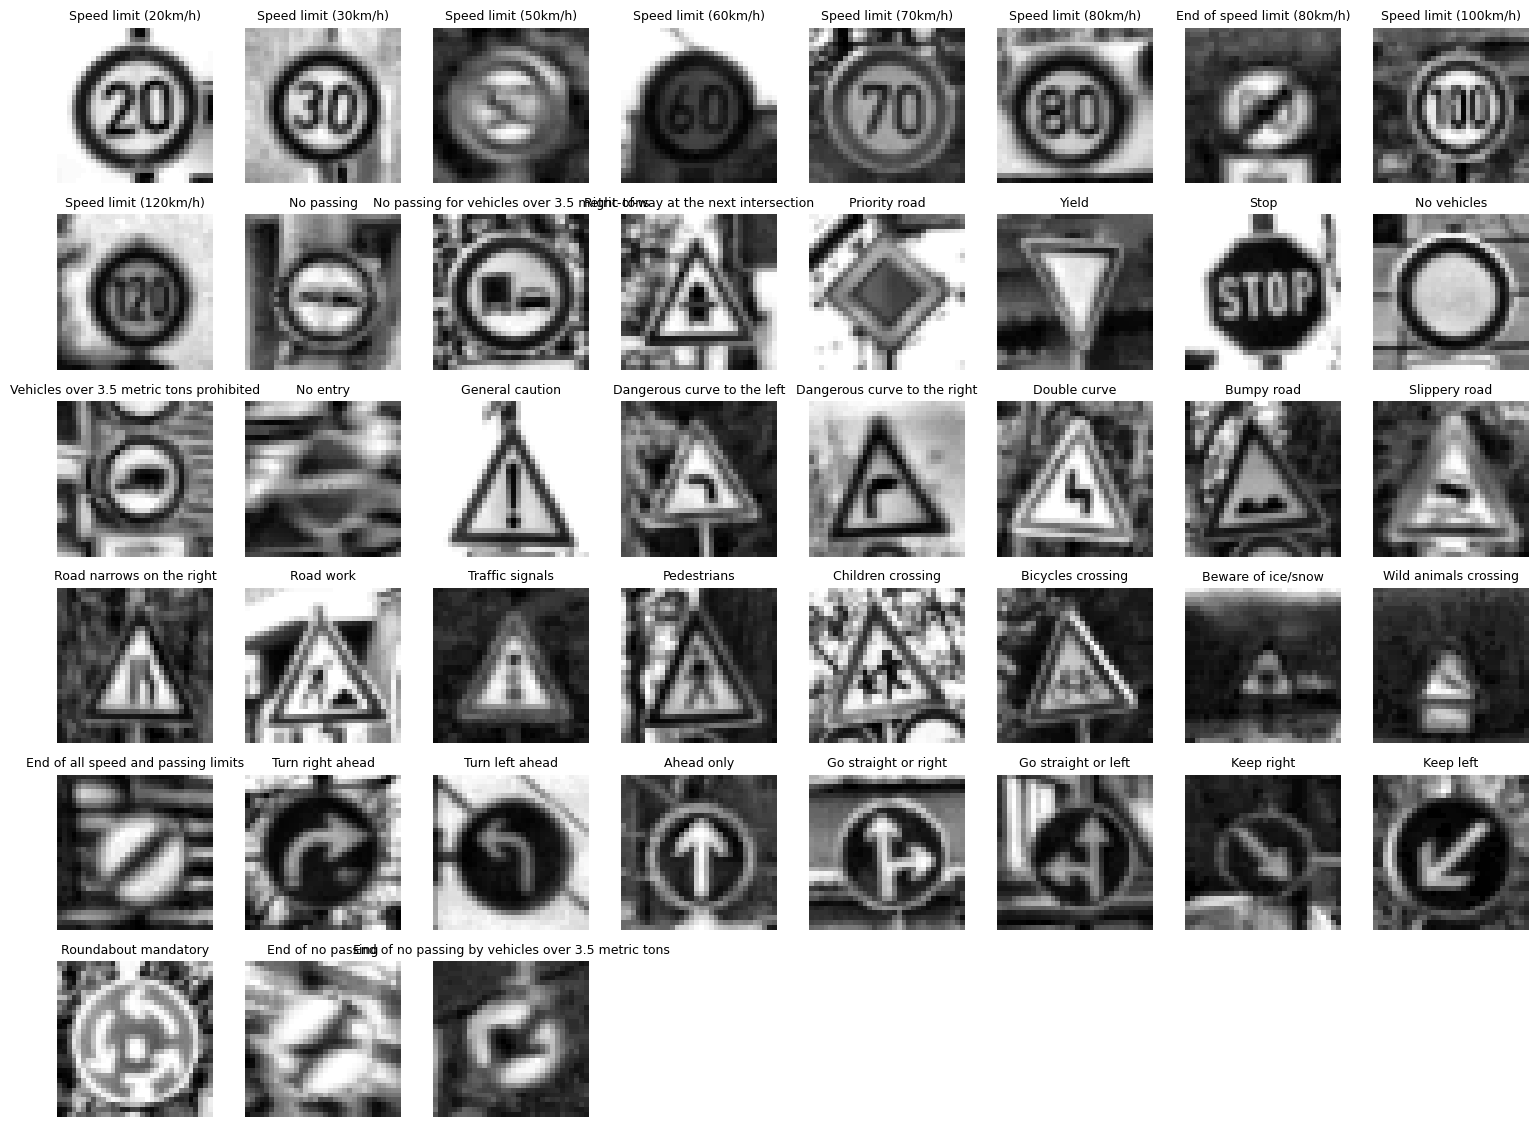

In [ ]:
plt.figure(figsize=(19, 19))
for c in range(len(set(y_test))):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title(label_names["SignName"][c], fontsize=9)
    plt.imshow(apply_clahe(X_train[i]).squeeze(), cmap='gray')

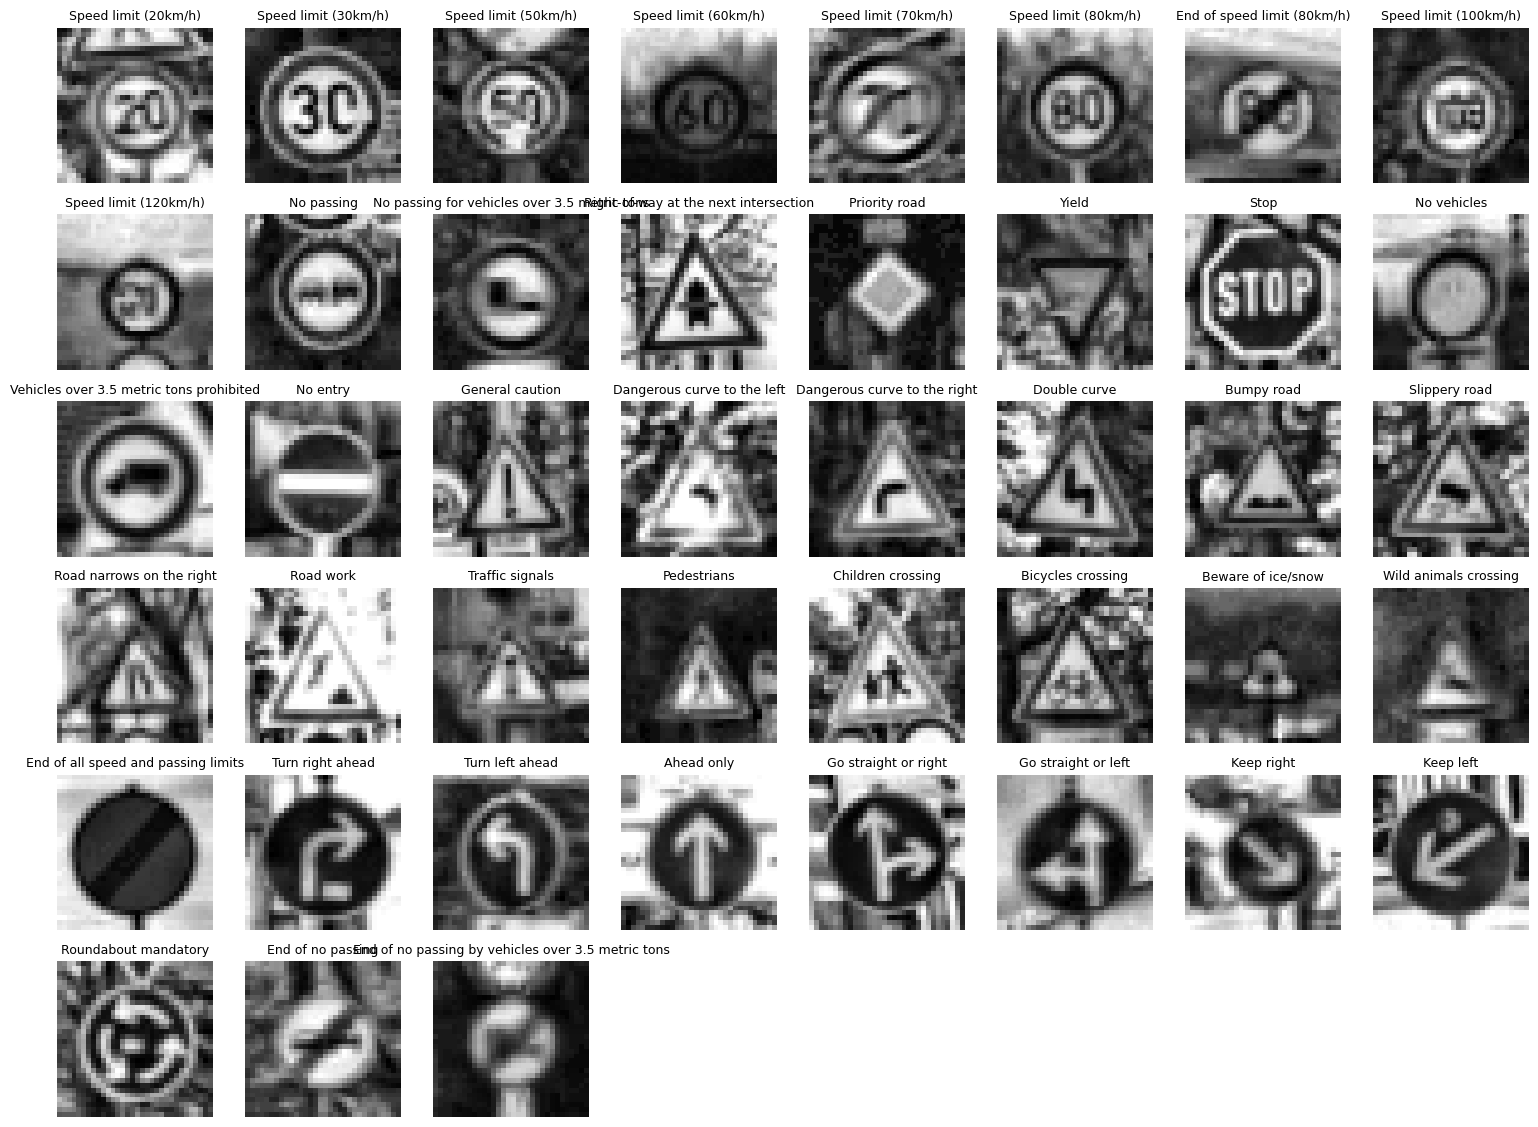

In [ ]:
plt.figure(figsize=(19, 19))
for c in range(len(set(y_test))):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title(label_names["SignName"][c], fontsize=9)
    plt.imshow(normalize(apply_clahe(X_train[i])).squeeze(), cmap='gray')

In [ ]:
data_transforms = transforms.Compose([
    apply_clahe,
    normalize,
    transforms.ToTensor()
])

In [ ]:
model = LeNet(gray=True).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20


Fitting nn model


  5%|▌         | 1/20 [00:06<02:10,  6.89s/it]


epoch:   1, loss: 1.55509, valid loss: 0.60256, valid accruacy: 80.930%
Validation loss decreased (inf --> 0.602562). Saving model...


 10%|█         | 2/20 [00:11<01:41,  5.62s/it]


epoch:   2, loss: 0.33569, valid loss: 0.40629, valid accruacy: 87.528%
Validation loss decreased (0.602562 --> 0.406290). Saving model...


 15%|█▌        | 3/20 [00:17<01:38,  5.79s/it]


epoch:   3, loss: 0.19009, valid loss: 0.32119, valid accruacy: 90.363%
Validation loss decreased (0.406290 --> 0.321189). Saving model...


 20%|██        | 4/20 [00:23<01:32,  5.79s/it]


epoch:   4, loss: 0.12354, valid loss: 0.27630, valid accruacy: 92.834%
Validation loss decreased (0.321189 --> 0.276302). Saving model...


 25%|██▌       | 5/20 [00:28<01:21,  5.42s/it]


epoch:   5, loss: 0.09288, valid loss: 0.29739, valid accruacy: 92.222%


 30%|███       | 6/20 [00:35<01:22,  5.90s/it]


epoch:   6, loss: 0.06887, valid loss: 0.25741, valid accruacy: 92.971%
Validation loss decreased (0.276302 --> 0.257413). Saving model...


 35%|███▌      | 7/20 [00:39<01:11,  5.52s/it]


epoch:   7, loss: 0.05776, valid loss: 0.29378, valid accruacy: 92.971%


 40%|████      | 8/20 [00:45<01:08,  5.74s/it]


epoch:   8, loss: 0.04309, valid loss: 0.24834, valid accruacy: 93.832%
Validation loss decreased (0.257413 --> 0.248337). Saving model...


 45%|████▌     | 9/20 [00:51<01:02,  5.64s/it]


epoch:   9, loss: 0.03614, valid loss: 0.25039, valid accruacy: 94.512%


 50%|█████     | 10/20 [00:56<00:55,  5.54s/it]


epoch:  10, loss: 0.03269, valid loss: 0.23757, valid accruacy: 94.218%
Validation loss decreased (0.248337 --> 0.237575). Saving model...


 55%|█████▌    | 11/20 [01:03<00:53,  5.93s/it]


epoch:  11, loss: 0.02655, valid loss: 0.24476, valid accruacy: 94.649%


 60%|██████    | 12/20 [01:08<00:44,  5.53s/it]


epoch:  12, loss: 0.02668, valid loss: 0.31447, valid accruacy: 93.311%


 65%|██████▌   | 13/20 [01:14<00:41,  5.90s/it]


epoch:  13, loss: 0.02287, valid loss: 0.25816, valid accruacy: 94.580%


 70%|███████   | 14/20 [01:19<00:33,  5.53s/it]


epoch:  14, loss: 0.01652, valid loss: 0.37222, valid accruacy: 93.537%


 75%|███████▌  | 15/20 [01:27<00:31,  6.37s/it]


epoch:  15, loss: 0.01945, valid loss: 0.30259, valid accruacy: 94.354%


 80%|████████  | 16/20 [01:33<00:24,  6.01s/it]


epoch:  16, loss: 0.01740, valid loss: 0.27852, valid accruacy: 94.467%


 85%|████████▌ | 17/20 [01:37<00:16,  5.62s/it]


epoch:  17, loss: 0.01597, valid loss: 0.34987, valid accruacy: 93.946%


 90%|█████████ | 18/20 [01:44<00:11,  5.96s/it]


epoch:  18, loss: 0.01393, valid loss: 0.28433, valid accruacy: 95.011%


 95%|█████████▌| 19/20 [01:49<00:05,  5.58s/it]


epoch:  19, loss: 0.01098, valid loss: 0.31404, valid accruacy: 94.444%


 95%|█████████▌| 19/20 [01:56<00:06,  6.12s/it]


epoch:  20, loss: 0.01281, valid loss: 0.25694, valid accruacy: 94.853%
Terminated Training for Early Stopping at Epoch 20
Fit time: 116.19439363479614 s


Test loss: 0.41791	Test accruacy: 91.227%
Saving model


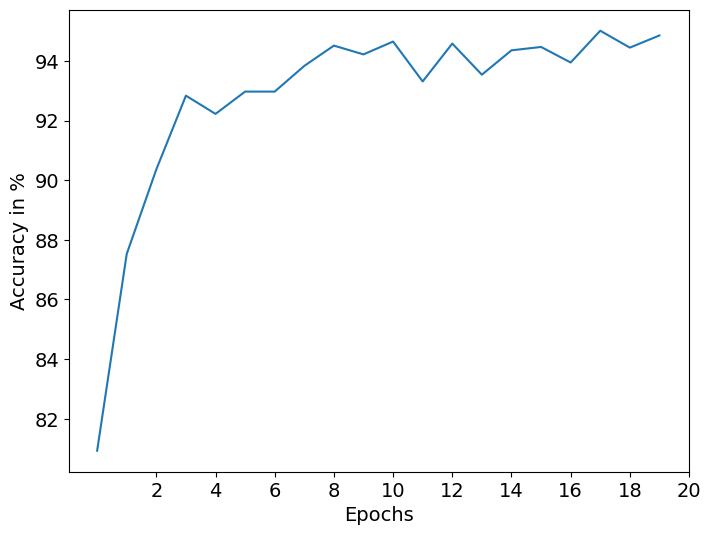

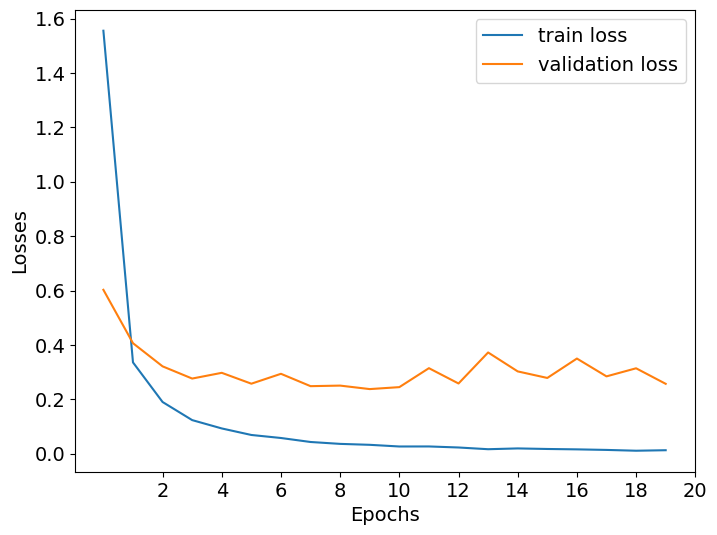

In [ ]:
train(model, criterion, optimizer, n_epochs, data_transforms, 'base_model_with_preprocessing')

In [ ]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img):
    ang_range = 25
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = augment_brightness_camera_images(img)

    return img

def get_random_image_of_given_label(images_set, labels_set, label):
    image_indexes = np.where(labels_set == label)
    rand_index = random.randint(0, np.bincount(labels_set)[label] - 1)
    return images_set[image_indexes][rand_index]

def equalize_samples_set(X_set, y_set):
    labels_count_arr = np.bincount(y_set)
    labels_bins = np.arange(len(labels_count_arr))

    ind = 0

    for label in tqdm(labels_bins, position=0, leave=True):
        labels_no_to_add =  int(np.mean(labels_count_arr)) * 4 - labels_count_arr[label]

        ind = ind + 1
        X_temp = []
        y_temp = []

        for num in range(labels_no_to_add):
            rand_image = get_random_image_of_given_label(X_set, y_set, label)
            X_temp.append(transform_image(rand_image))
            y_temp.append(label)

        X_set = np.append(X_set, np.array(X_temp), axis=0)
        y_set = np.append(y_set, np.array(y_temp), axis=0)

    return X_set, y_set

100%|██████████| 43/43 [01:18<00:00,  1.83s/it]


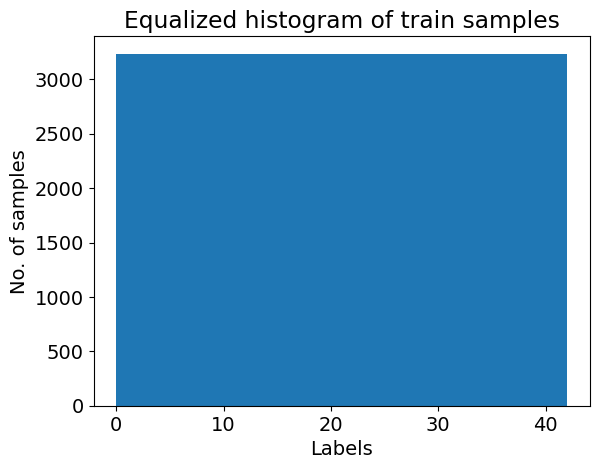

Train set increased from 34799 to 139148


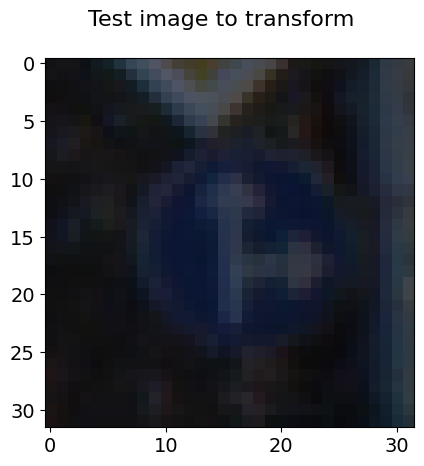

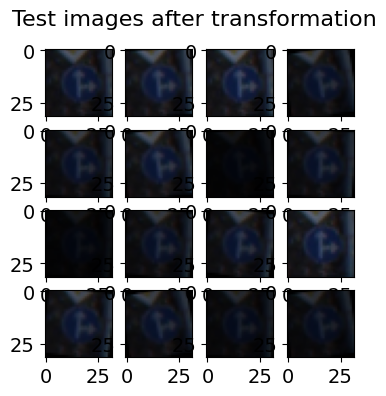

In [ ]:
# X_train = normalize(apply_clahe(X_train))

n_train = len(X_train)
X_train, y_train = equalize_samples_set(X_train, y_train)

n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Equalized histogram of train samples')
plt.show()

print("Train set increased from {} to {}".format(n_train,X_train.shape[0]))

fig=plt.figure()
fig.suptitle('Test image to transform', fontsize=16)
plt.imshow(X_train[1000])

grid_len = 4
fig=plt.figure(figsize=(grid_len,grid_len))
fig.suptitle('Test images after transformation', fontsize=16)

for i in range(1,grid_len*grid_len+1):
    image = transform_image(X_train[1000])
    plt.subplot(grid_len,grid_len,i)
    plt.imshow(image)

In [ ]:
extended_train_path = 'drive/My Drive/Colab Notebooks/lab2_dataset/train_extended.pickle'

In [ ]:
extended_train_data = {
    'features': X_train,
    'labels': y_train,
    'sizes': [],
    'coords': [],
}

with open(extended_train_path, 'wb') as handle:
    pickle.dump(extended_train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model = LeNet(gray=True).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20


Fitting nn model


  5%|▌         | 1/20 [00:23<07:29, 23.65s/it]


epoch:   1, loss: 0.72553, valid loss: 0.29704, valid accruacy: 90.907%
Validation loss decreased (inf --> 0.297038). Saving model...


 10%|█         | 2/20 [00:43<06:29, 21.61s/it]


epoch:   2, loss: 0.17213, valid loss: 0.28913, valid accruacy: 92.948%
Validation loss decreased (0.297038 --> 0.289135). Saving model...


 15%|█▌        | 3/20 [01:05<06:10, 21.81s/it]


epoch:   3, loss: 0.10425, valid loss: 0.25150, valid accruacy: 94.014%
Validation loss decreased (0.289135 --> 0.251501). Saving model...


 20%|██        | 4/20 [01:25<05:36, 21.01s/it]


epoch:   4, loss: 0.07364, valid loss: 0.35015, valid accruacy: 93.651%


 25%|██▌       | 5/20 [01:47<05:19, 21.32s/it]


epoch:   5, loss: 0.05723, valid loss: 0.36416, valid accruacy: 94.354%


 30%|███       | 6/20 [02:07<04:50, 20.73s/it]


epoch:   6, loss: 0.04477, valid loss: 0.34949, valid accruacy: 95.488%


 35%|███▌      | 7/20 [02:30<04:40, 21.54s/it]


epoch:   7, loss: 0.03798, valid loss: 0.34541, valid accruacy: 95.533%


 40%|████      | 8/20 [02:51<04:18, 21.57s/it]


epoch:   8, loss: 0.03162, valid loss: 0.35816, valid accruacy: 94.671%


 45%|████▌     | 9/20 [03:12<03:52, 21.14s/it]


epoch:   9, loss: 0.02875, valid loss: 0.36055, valid accruacy: 95.238%


 50%|█████     | 10/20 [03:32<03:29, 20.90s/it]


epoch:  10, loss: 0.02421, valid loss: 0.36523, valid accruacy: 95.646%


 55%|█████▌    | 11/20 [03:53<03:08, 20.95s/it]


epoch:  11, loss: 0.02119, valid loss: 0.31643, valid accruacy: 96.054%


 60%|██████    | 12/20 [04:14<02:48, 21.01s/it]


epoch:  12, loss: 0.02023, valid loss: 0.36260, valid accruacy: 94.921%


 60%|██████    | 12/20 [04:35<03:03, 22.93s/it]


epoch:  13, loss: 0.01923, valid loss: 0.29258, valid accruacy: 96.054%
Terminated Training for Early Stopping at Epoch 13
Fit time: 275.1463177204132 s


Test loss: 0.37294	Test accruacy: 91.338%
Saving model


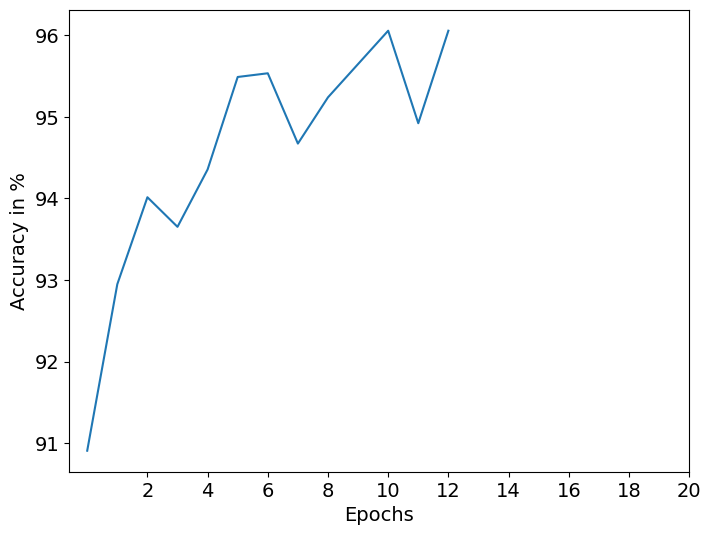

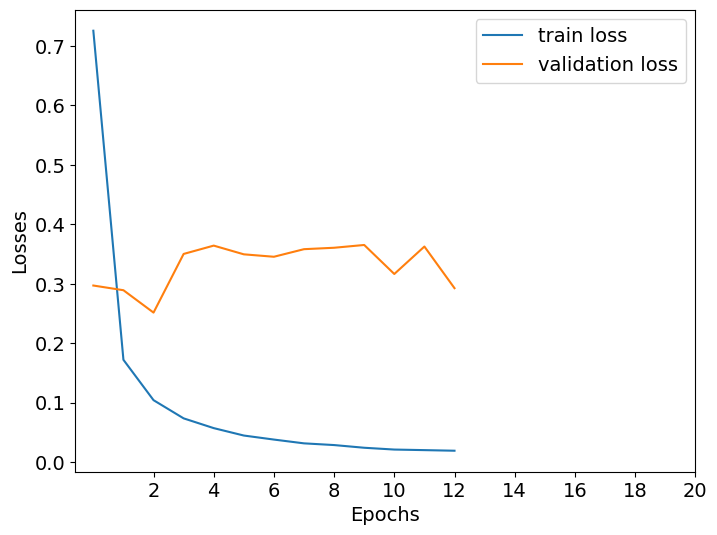

In [ ]:
train(model, criterion, optimizer, n_epochs, data_transforms, 'base_model_with_preprocessing_and_extended', extended_train_path)

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [ ]:
model = TrafficSignNet().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Adam is sooooo goood!
n_epochs = 100


Fitting nn model


  1%|          | 1/100 [00:27<45:21, 27.49s/it]


epoch:   1, loss: 1.27186, valid loss: 0.34798, valid accruacy: 91.633%
Validation loss decreased (inf --> 0.347980). Saving model...


  2%|▏         | 2/100 [00:54<44:16, 27.11s/it]


epoch:   2, loss: 0.37851, valid loss: 0.13903, valid accruacy: 96.553%
Validation loss decreased (0.347980 --> 0.139031). Saving model...


  3%|▎         | 3/100 [01:21<43:41, 27.03s/it]


epoch:   3, loss: 0.23313, valid loss: 0.10453, valid accruacy: 97.347%
Validation loss decreased (0.139031 --> 0.104535). Saving model...


  4%|▍         | 4/100 [01:48<43:12, 27.01s/it]


epoch:   4, loss: 0.17555, valid loss: 0.08917, valid accruacy: 97.687%
Validation loss decreased (0.104535 --> 0.089172). Saving model...


  5%|▌         | 5/100 [02:15<42:39, 26.94s/it]


epoch:   5, loss: 0.14618, valid loss: 0.07802, valid accruacy: 97.778%
Validation loss decreased (0.089172 --> 0.078023). Saving model...


  6%|▌         | 6/100 [02:44<43:19, 27.66s/it]


epoch:   6, loss: 0.12703, valid loss: 0.07623, valid accruacy: 97.800%
Validation loss decreased (0.078023 --> 0.076231). Saving model...


  7%|▋         | 7/100 [03:10<42:22, 27.34s/it]


epoch:   7, loss: 0.11127, valid loss: 0.07743, valid accruacy: 98.005%


  8%|▊         | 8/100 [03:37<41:35, 27.12s/it]


epoch:   8, loss: 0.10151, valid loss: 0.07588, valid accruacy: 98.050%
Validation loss decreased (0.076231 --> 0.075883). Saving model...


  9%|▉         | 9/100 [04:04<40:52, 26.95s/it]


epoch:   9, loss: 0.09189, valid loss: 0.07754, valid accruacy: 98.005%


 10%|█         | 10/100 [04:30<40:22, 26.92s/it]


epoch:  10, loss: 0.08538, valid loss: 0.07930, valid accruacy: 98.095%


 11%|█         | 11/100 [04:57<39:48, 26.84s/it]


epoch:  11, loss: 0.08002, valid loss: 0.06783, valid accruacy: 98.141%
Validation loss decreased (0.075883 --> 0.067832). Saving model...


 12%|█▏        | 12/100 [05:24<39:12, 26.74s/it]


epoch:  12, loss: 0.07403, valid loss: 0.07239, valid accruacy: 98.027%


 13%|█▎        | 13/100 [05:50<38:43, 26.70s/it]


epoch:  13, loss: 0.06960, valid loss: 0.06094, valid accruacy: 98.209%
Validation loss decreased (0.067832 --> 0.060937). Saving model...


 14%|█▍        | 14/100 [06:17<38:20, 26.75s/it]


epoch:  14, loss: 0.06697, valid loss: 0.06014, valid accruacy: 98.322%
Validation loss decreased (0.060937 --> 0.060137). Saving model...


 15%|█▌        | 15/100 [06:44<37:46, 26.67s/it]


epoch:  15, loss: 0.06451, valid loss: 0.05831, valid accruacy: 98.367%
Validation loss decreased (0.060137 --> 0.058312). Saving model...


 16%|█▌        | 16/100 [07:10<37:18, 26.65s/it]


epoch:  16, loss: 0.06100, valid loss: 0.06939, valid accruacy: 98.277%


 17%|█▋        | 17/100 [07:39<37:46, 27.31s/it]


epoch:  17, loss: 0.05921, valid loss: 0.05697, valid accruacy: 98.435%
Validation loss decreased (0.058312 --> 0.056975). Saving model...


 18%|█▊        | 18/100 [08:05<37:00, 27.07s/it]


epoch:  18, loss: 0.05732, valid loss: 0.05903, valid accruacy: 98.390%


 19%|█▉        | 19/100 [08:31<35:58, 26.65s/it]


epoch:  19, loss: 0.05385, valid loss: 0.05587, valid accruacy: 98.481%
Validation loss decreased (0.056975 --> 0.055868). Saving model...


 20%|██        | 20/100 [08:57<35:13, 26.42s/it]


epoch:  20, loss: 0.05203, valid loss: 0.06708, valid accruacy: 98.345%


 21%|██        | 21/100 [09:23<34:32, 26.24s/it]


epoch:  21, loss: 0.05130, valid loss: 0.06808, valid accruacy: 98.345%


 22%|██▏       | 22/100 [09:48<33:46, 25.98s/it]


epoch:  22, loss: 0.04905, valid loss: 0.05722, valid accruacy: 98.345%


 23%|██▎       | 23/100 [10:14<33:06, 25.80s/it]


epoch:  23, loss: 0.04846, valid loss: 0.06578, valid accruacy: 98.345%


 24%|██▍       | 24/100 [10:39<32:33, 25.70s/it]


epoch:  24, loss: 0.04659, valid loss: 0.05507, valid accruacy: 98.503%
Validation loss decreased (0.055868 --> 0.055067). Saving model...


 25%|██▌       | 25/100 [11:04<31:59, 25.60s/it]


epoch:  25, loss: 0.04518, valid loss: 0.05706, valid accruacy: 98.367%


 26%|██▌       | 26/100 [11:30<31:36, 25.63s/it]


epoch:  26, loss: 0.04438, valid loss: 0.07322, valid accruacy: 98.299%


 27%|██▋       | 27/100 [11:56<31:10, 25.63s/it]


epoch:  27, loss: 0.04321, valid loss: 0.06398, valid accruacy: 98.413%


 28%|██▊       | 28/100 [12:24<31:31, 26.28s/it]


epoch:  28, loss: 0.04259, valid loss: 0.06865, valid accruacy: 98.367%


 29%|██▉       | 29/100 [12:49<30:41, 25.94s/it]


epoch:  29, loss: 0.04212, valid loss: 0.07401, valid accruacy: 98.322%


 30%|███       | 30/100 [13:15<30:13, 25.91s/it]


epoch:  30, loss: 0.04098, valid loss: 0.06107, valid accruacy: 98.345%


 31%|███       | 31/100 [13:40<29:38, 25.78s/it]


epoch:  31, loss: 0.04091, valid loss: 0.07561, valid accruacy: 98.299%


 32%|███▏      | 32/100 [14:05<29:06, 25.69s/it]


epoch:  32, loss: 0.03967, valid loss: 0.07423, valid accruacy: 98.322%


 33%|███▎      | 33/100 [14:31<28:38, 25.65s/it]


epoch:  33, loss: 0.03861, valid loss: 0.07869, valid accruacy: 98.413%


 33%|███▎      | 33/100 [14:56<30:20, 27.17s/it]


epoch:  34, loss: 0.03758, valid loss: 0.06462, valid accruacy: 98.458%
Terminated Training for Early Stopping at Epoch 34
Fit time: 896.6673350334167 s


Test loss: 0.07945	Test accruacy: 97.530%
Saving model


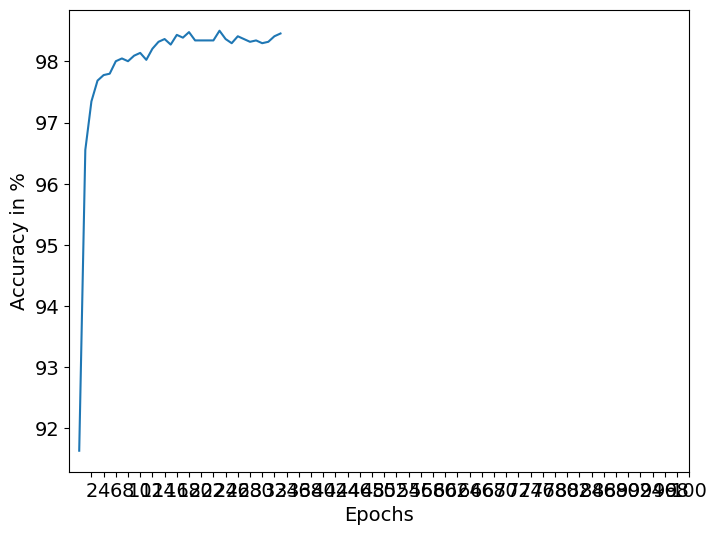

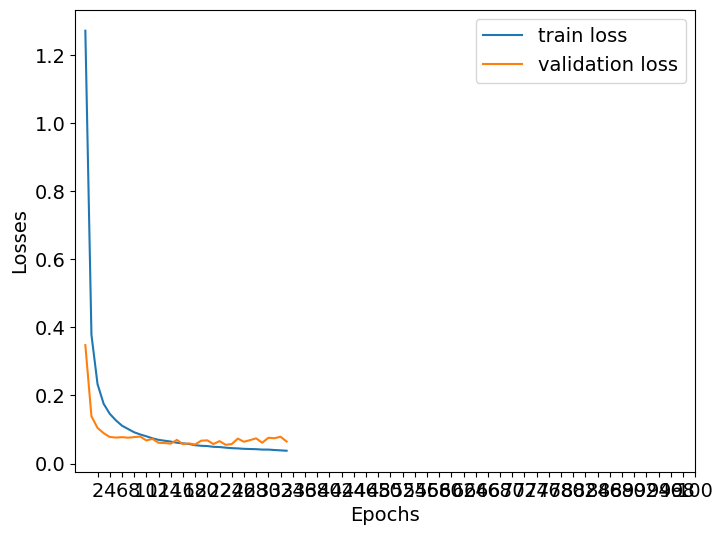

In [ ]:
train(model, criterion, optimizer, n_epochs, data_transforms, 'MCDNN', extended_train_path)

In [ ]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [ ]:
class TrafficSignNetStn(nn.Module):
    def __init__(self):
        super(TrafficSignNetStn, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [ ]:
model = TrafficSignNetStn().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Adam is sooooo goood!
n_epochs = 100


Fitting nn model


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  1%|          | 1/100 [00:31<51:23, 31.15s/it]


epoch:   1, loss: 0.94111, valid loss: 0.12845, valid accruacy: 97.370%
Validation loss decreased (inf --> 0.128451). Saving model...


  2%|▏         | 2/100 [01:04<52:38, 32.23s/it]


epoch:   2, loss: 0.16648, valid loss: 0.06575, valid accruacy: 98.571%
Validation loss decreased (0.128451 --> 0.065746). Saving model...


  3%|▎         | 3/100 [01:35<51:28, 31.84s/it]


epoch:   3, loss: 0.09603, valid loss: 0.06916, valid accruacy: 98.526%


  4%|▍         | 4/100 [02:08<51:45, 32.35s/it]


epoch:   4, loss: 0.06668, valid loss: 0.05379, valid accruacy: 98.571%
Validation loss decreased (0.065746 --> 0.053794). Saving model...


  5%|▌         | 5/100 [02:39<50:32, 31.92s/it]


epoch:   5, loss: 0.05155, valid loss: 0.05256, valid accruacy: 98.730%
Validation loss decreased (0.053794 --> 0.052557). Saving model...


  6%|▌         | 6/100 [03:12<50:16, 32.09s/it]


epoch:   6, loss: 0.04392, valid loss: 0.05563, valid accruacy: 98.639%


  7%|▋         | 7/100 [03:43<49:15, 31.78s/it]


epoch:   7, loss: 0.03566, valid loss: 0.04456, valid accruacy: 98.685%
Validation loss decreased (0.052557 --> 0.044556). Saving model...


  8%|▊         | 8/100 [04:15<49:08, 32.05s/it]


epoch:   8, loss: 0.03059, valid loss: 0.06491, valid accruacy: 98.571%


  9%|▉         | 9/100 [04:47<48:19, 31.86s/it]


epoch:   9, loss: 0.02877, valid loss: 0.06425, valid accruacy: 98.549%


 10%|█         | 10/100 [05:19<48:06, 32.07s/it]


epoch:  10, loss: 0.02486, valid loss: 0.06845, valid accruacy: 98.413%


 11%|█         | 11/100 [05:50<47:05, 31.74s/it]


epoch:  11, loss: 0.02317, valid loss: 0.05537, valid accruacy: 98.707%


 12%|█▏        | 12/100 [06:23<46:46, 31.89s/it]


epoch:  12, loss: 0.02054, valid loss: 0.05423, valid accruacy: 98.753%


 13%|█▎        | 13/100 [06:55<46:28, 32.05s/it]


epoch:  13, loss: 0.01912, valid loss: 0.03771, valid accruacy: 99.025%
Validation loss decreased (0.044556 --> 0.037710). Saving model...


 14%|█▍        | 14/100 [07:28<46:09, 32.21s/it]


epoch:  14, loss: 0.01831, valid loss: 0.04222, valid accruacy: 98.934%


 15%|█▌        | 15/100 [07:59<45:11, 31.91s/it]


epoch:  15, loss: 0.01608, valid loss: 0.04745, valid accruacy: 98.912%


 16%|█▌        | 16/100 [08:32<45:04, 32.20s/it]


epoch:  16, loss: 0.01567, valid loss: 0.06190, valid accruacy: 98.662%


 17%|█▋        | 17/100 [09:03<44:07, 31.90s/it]


epoch:  17, loss: 0.01523, valid loss: 0.05103, valid accruacy: 98.821%


 18%|█▊        | 18/100 [09:36<44:04, 32.25s/it]


epoch:  18, loss: 0.01489, valid loss: 0.04507, valid accruacy: 98.866%


 19%|█▉        | 19/100 [10:07<43:09, 31.97s/it]


epoch:  19, loss: 0.01307, valid loss: 0.06381, valid accruacy: 98.730%


 20%|██        | 20/100 [10:40<42:43, 32.04s/it]


epoch:  20, loss: 0.01307, valid loss: 0.05696, valid accruacy: 98.753%


 21%|██        | 21/100 [11:11<41:48, 31.76s/it]


epoch:  21, loss: 0.01286, valid loss: 0.06404, valid accruacy: 98.798%


 22%|██▏       | 22/100 [11:44<41:56, 32.26s/it]


epoch:  22, loss: 0.01240, valid loss: 0.04037, valid accruacy: 99.184%


 22%|██▏       | 22/100 [12:15<43:28, 33.45s/it]


epoch:  23, loss: 0.01141, valid loss: 0.09277, valid accruacy: 98.639%
Terminated Training for Early Stopping at Epoch 23
Fit time: 735.8253929615021 s


Test loss: 0.05859	Test accruacy: 98.480%
Saving model


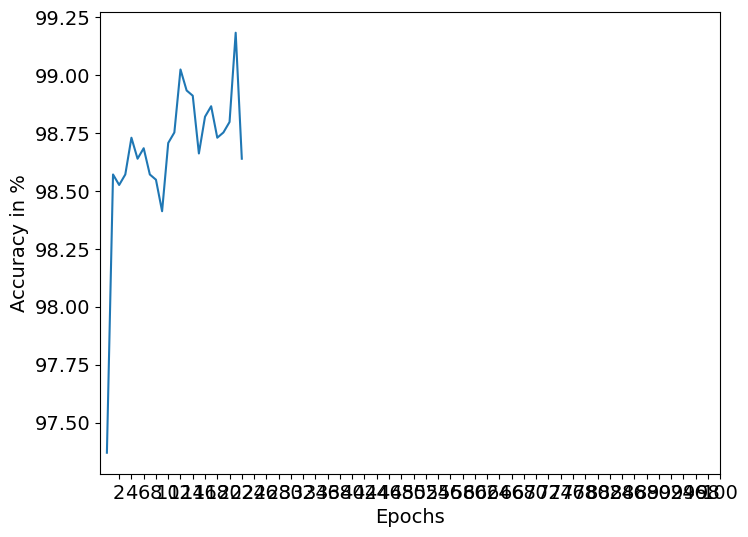

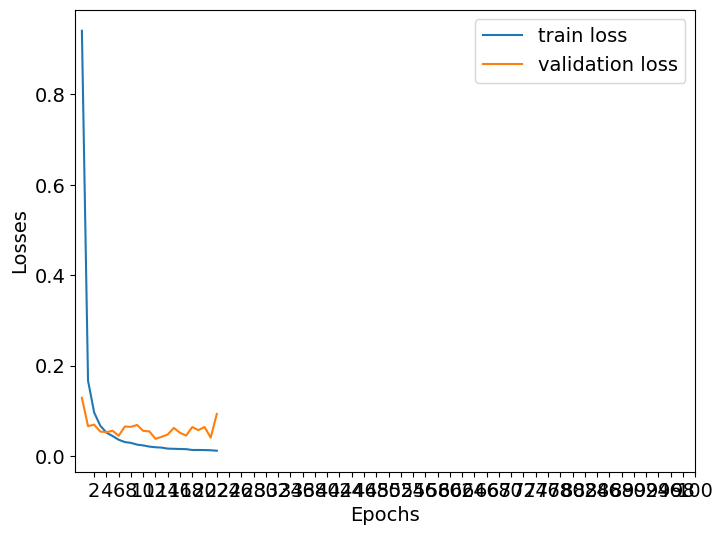

In [ ]:
train(model, criterion, optimizer, n_epochs, data_transforms, 'MCDNN_STN', extended_train_path)